In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

import pyro
import pyro.distributions as dist
from torch import nn
from pyro.nn import PyroModule
from torch.distributions import constraints
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.infer import Predictive
import pyro.optim as optim
from IPython.display import Image

# Pyro vocabulary
---


- `model` : any function is a model.
It is a "composition of primitive stochastic functions and deterministic computations".

A stochastic function can be any Python object with a `__call__()` method, like a function, a method, or a PyTorch `nn.Module`.

- `guide` : follows the model

- `sample` : get a collection of independent rv from the same primitive and `name` it


- `shapes` : observations are non scalars


_  | iid | independent | dependent
--- | --- | --- | ---
*shape* | `sample_shape` | `batch_shape` | `event_shape`

- `condition` : set the value of one or more variables for a model

- `model` : any function is a model.

- `guide` : follows the model

### `model`

$p_\theta ({\bf x}, {\bf z}) = p({\bf x} | {\bf z}) p_\theta({\bf z})$

parts of the model:
 
- constants : `alpha0 = torch.tensor(10.)`

- parameters : `pyro.param("alpha_q", torch.tensor(10.), constraint=constraints.positive)`

- latent variables : `pyro.sample("nu", dist.Beta(alpha0, beta0))`

- observables : `pyro.sample('obs', dist.Bernoulli(f), obs=data)`

NB: `model` has at least three components!

observable $x$, latent variable $z$ and parameters of the latent variable $\theta$

${\bf x} \gets {\bf z} \gets \theta$

assumption on probability distributions $p_i$

- we can sample from each $p_i$

- we can compute the pointwise logprob for each $p_i$

- each $p_i$ is differentiable w.r.t. its parameters

MLE: $${\bf z}_{max} = \mbox{argmax} \, \log p({\bf x} | {\bf z} )$$

but we are one step above in complexity, so 


we are interested in :

$$\theta_{max} = \mbox{argmax} \, \log p_\theta ({\bf x})$$


$$\log p_{\theta}({\bf x}) = \log \int\! d{\bf z}\; p_{\theta}({\bf x}, {\bf z})$$

Issues:
the intergral is often intractable, optimization problem might be non-convex.

we are also interested in posterior distribution:

$$ p_{\theta_{\rm{max}}}({\bf z} | {\bf x}) = \frac{p_{\theta_{\rm{max}}}({\bf x} , {\bf z})}{
\int \! d{\bf z}\; p_{\theta_{\rm{max}}}({\bf x} , {\bf z}) }$$

### `guide`

we introduce a parametrized the distribution of the latent variable, an `approximation` (!) to the posterior.

$q_\phi ({\bf z})$

It is customarily called the variational distribution. In pyro it is called `guide`.



NB: `guide` has the same signature as `model`, so it has to have observable data as input $x$, but it never uses it

Neither `model` nor `guide` have to return anything

${\bf z} \gets \phi$

Since the guide is an approximation to the posterior $p_{\theta_{\rm{max}}}({\bf z} | {\bf x})$, the guide needs to provide a valid joint probability density over all the latent random variables in the model.

So if `model` introduces a random variable with `sample` statement and calls it `z_1`, the `guide` should contain it.

There 1-1 correspondance in the names scheme (the structure and distibution may be different).



```python
def model():
    pyro.sample("z_1", ...)
```

```python
def guide():
    pyro.sample("z_1", ...)
```

## ELBO

The evidence lower bound (ELBO).

$$
{\rm ELBO} \equiv \mathbb{E}_{q_{\phi}({\bf z})} \left [
\log p_{\theta}({\bf x}, {\bf z}) - \log q_{\phi}({\bf z})
\right]
$$

$\log p_\theta$ is computable and we can intergrate over $q$

ELBO is the lower bound for log evidence.

$$\log p_{\theta}({\bf x}) \ge {\rm ELBO}$$


$$\log p_{\theta}({\bf x}) - {\rm ELBO} =
\rm{KL}\!\left( q_{\phi}({\bf z}) \lVert p_{\theta}({\bf z} | {\bf x}) \right)$$

NB: KL divergence is non-negative.

So we have two parts : the relative distance between $q_{\phi}$ and $p_\theta$ and $\log p_{\theta}({\bf x})$

For a fixed $\theta$, as we take steps in $\phi$ space that increase the ELBO, we decrease the KL divergence between the guide and the posterior, i.e. we move the guide towards the posterior. Then we take the step $\theta$ and increase the evidence.

In the general case we take gradient steps in both $\theta$ and $\phi$  space simultaneously so that the guide and model play chase, with the guide tracking a moving posterior. 
And it works.

So now we list the required components:
`model`, `guide`, `loss`, `optimizer` and `engine`.

```python
import pyro
from pyro.infer import SVI, Trace_ELBO
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
```

The SVI object provides two methods, `step()` and `evaluate_loss()`, 
that encapsulate the logic for variational learning and evaluation:

- The method `step()` takes a single gradient step and returns an estimate of the loss (i.e. minus the ELBO). If provided, the arguments to `step()` are piped to `model()` and `guide()`

 - The method `evaluate_loss()` returns an estimate of the loss without taking a gradient step. Just like for `step()`, if provided, arguments to `evaluate_loss()` are piped to `model()` and `guide()`.

## extras 

- `pyro.clear_param_store()`

- `autoguides`

- `dist.Normal(0, 1).expand([out_dim])`
    
    equivalent to pyro.sample() call

- `dist.Normal(0, 1).expand([out_dim]).to_event(1))`
    tells to consider 1 dimension from the right as dependent

In [2]:
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import pandas as pd


pyro.clear_param_store()

n_steps = 1000

data = []
for _ in range(9):
    data.append(torch.tensor(1.0))
for _ in range(1):
    data.append(torch.tensor(0.0))
    
data = torch.FloatTensor(data)

def model(data):
    alpha0 = torch.tensor(10.)
    beta0 = torch.tensor(10.)
    f = pyro.sample("nu", dist.Beta(alpha0, beta0))
    with pyro.plate('data', len(data)):
        pyro.sample('obs', dist.Bernoulli(f), obs=data)

def guide(data):
    alpha_q = pyro.param("alpha_q", torch.tensor(10.),
                         constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(10.),
                        constraint=constraints.positive)
    pyro.sample("nu", dist.Beta(alpha_q, beta_q))

In [3]:
# setup the optimizer
adam_params = {"lr": 0.0005}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# do gradient steps
losses = []
for step in range(n_steps):
    losses += [svi.step(data)]
    if step % 100 == 0:
        print('.', end='')

# grab the learned variational parameters
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()
alpha_q, beta_q

..........

(12.380888938903809, 8.055330276489258)

In [4]:
# here we use some facts about the beta distribution
# compute the inferred mean of the coin's fairness
inferred_mean = alpha_q / (alpha_q + beta_q)
# compute inferred standard deviation
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)

print("\nbased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))


based on the data and our prior belief, the fairness of the coin is 0.606 +- 0.106


In [5]:
(9 + 10 + 1) /(10 + 10 + 10 + 1)

0.6451612903225806

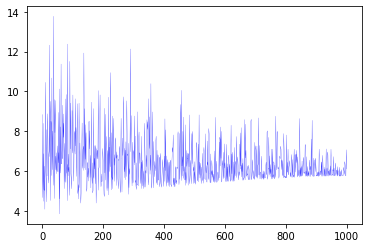

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

line, = ax.plot(losses, color='blue', lw=0.2)

# ax = plt.plot(losses)
# ax.set_yscale('log')

In [8]:
params = pyro.get_param_store()

In [10]:
params.keys()

dict_keys(['alpha_q', 'beta_q'])